In [43]:
import torch
import torch.nn.functional as F
from train_ddpd import DDPDConfig
from sample_ddpd import load_models, decode_tokens
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

checkpoint = "/home/ubuntu/simo/ddpd/checkpoints/checkpoint_iter_2800.pt"
device = "cuda"
planner, denoiser = load_models(checkpoint, device)




/home/ubuntu/simo/ddpd/sample_ddpd.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Rotary half of head dim: 64
Rotary half of head dim: 64


In [2]:
from train_ddpd import MNISTTokenDataset

dataset = MNISTTokenDataset()

Initializing MNISTTokenDataset
Total samples: 60000


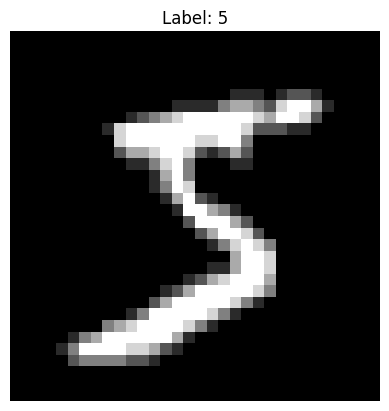

In [3]:
image, label = dataset[0]

# visualize image
plt.imshow(image.reshape(32, 32), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [44]:

torch.set_grad_enabled(False)

num_steps = 300
num_samples = 10
label = 6
time_steps = torch.linspace(1.0, 0.00, num_steps, device=device)

images = []
mask_images = []

x = torch.randint(0, planner.config.vocab_size - 1, (1, 32 * 32), device=device)
class_labels = torch.tensor([label], device=device)

for idx, t in enumerate(time_steps):
    current_t = torch.full((1,), t, device=device)
    
    # Get planner predictions
    planner_logits = planner(x, current_t, class_labels)
    planner_probs = torch.sigmoid(planner_logits / 0.1)
    
    time_estimated = planner_probs.mean().item()
    print(f"Time estimated: {time_estimated}")
    
    
    current_t = torch.full((1,), time_estimated, device=device)
    
    # Create mask based on planner predictions
    if idx == len(time_steps) - 1:
        mask = planner_probs > 0.5
    else:
        change_dim = torch.multinomial(planner_probs, num_samples=num_samples)
        mask = torch.zeros_like(planner_probs.squeeze(-1), dtype=torch.bool)
        mask.scatter_(1, change_dim, True)
    
    mask_images.append(planner_probs.cpu().numpy().reshape(32, 32) * 255)
    
    if mask.sum() > 0:
        denoiser_logits = denoiser(x, current_t, class_labels)
        
        masked_logits = denoiser_logits[mask]
        if idx == len(time_steps) - 1:
            masked_logits = masked_logits / 0.01
        else:
            masked_logits = masked_logits / 1.0
        probs = F.softmax(masked_logits, dim=-1)
        next_tokens = torch.multinomial(probs, num_samples=1).squeeze(-1)
        x[mask] = next_tokens
    
    # Plot current state (denormalize back to 0-255)
    current_image = x.reshape(32, 32).float()
    current_image = (current_image / 7.0 * 255).clamp(0, 255).cpu().numpy()
    images.append(current_image)
    
    if time_estimated < 0.01:
        break
    

Time estimated: 1.0
Time estimated: 1.0
Time estimated: 1.0
Time estimated: 0.9999999403953552
Time estimated: 0.9999986886978149
Time estimated: 0.9999902248382568
Time estimated: 0.999948263168335
Time estimated: 0.9998177886009216
Time estimated: 0.9993286728858948
Time estimated: 0.9966922998428345
Time estimated: 0.9904999136924744
Time estimated: 0.9849319458007812
Time estimated: 0.9657723903656006
Time estimated: 0.9343313574790955
Time estimated: 0.8908877372741699
Time estimated: 0.8557959794998169
Time estimated: 0.8317698836326599
Time estimated: 0.8119969367980957
Time estimated: 0.7947820425033569
Time estimated: 0.779273271560669
Time estimated: 0.7739664912223816
Time estimated: 0.7635278701782227
Time estimated: 0.7546565532684326
Time estimated: 0.7470752000808716
Time estimated: 0.7377703189849854
Time estimated: 0.7281231880187988
Time estimated: 0.7164265513420105
Time estimated: 0.7040533423423767
Time estimated: 0.6906260251998901
Time estimated: 0.67678678035736

In [45]:
# visualize images as gif, concat mask_images and images left to right
mask_images = np.array(mask_images)
images = np.array(images)

# concat horizontally
all_images = np.concatenate([mask_images, images], axis=2)

# put "planner" and "state" on top of all_images
new_images = []
from PIL import Image, ImageDraw

new_resolution = 256

for i in range(all_images.shape[0]):
    # Create a blank canvas with white background
    canvas_width = new_resolution * 2
    canvas_height = new_resolution + 32
    blank_image = Image.new('RGB', (canvas_width, canvas_height), 'white')
    
    # Resize and paste the current image
    img = Image.fromarray(all_images[i]).resize((canvas_width, new_resolution), Image.Resampling.NEAREST)
    blank_image.paste(img, (0, 32))
    
    # Add text labels
    draw = ImageDraw.Draw(blank_image)
    draw.text((10, 10), "planner", fill="red", font=None)
    draw.text((new_resolution + 5, 10), "state", fill="blue", font=None)
    
    new_images.append(blank_image)

# visualize all_images as gif
import imageio
imageio.mimsave('all_images.mp4', new_images, fps=10)


In [19]:
indices = image.reshape(1, -1)
indices = indices.to(device)
print(indices.shape)
t = torch.tensor([0.9], device=device)
mask = torch.bernoulli(t.unsqueeze(1).expand(-1, indices.shape[1])).bool()

input_indices = indices.clone()
MASK_IDX = planner.config.vocab_size - 1
num_masked = mask.sum().item()
if num_masked > 0:
    input_indices[mask] = torch.randint(
        0, MASK_IDX, (num_masked,), device=device
    )


torch.Size([1, 1024])


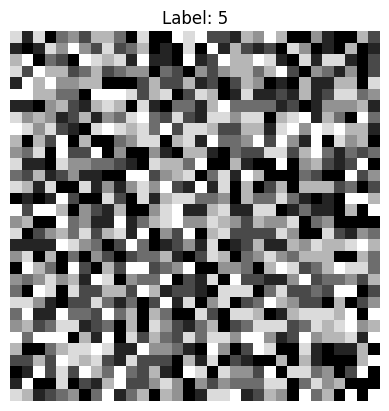

In [20]:
# visualize input_indices
plt.imshow(input_indices.cpu().numpy().reshape(32, 32), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()